In [15]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Apr 16 15:41:44 2022

@author: jackchen


# 這個腳本是從[tmp]Reorganize_results.py改過來的,也刪減掉除了準備Table之外的其他部分

"""

import os, glob
import pandas as pd
import numpy as np
import re
from addict import Dict
import articulation.HYPERPARAM.FeatureSelect as FeatSel
import articulation.HYPERPARAM.PaperNameMapping as PprNmeMp
import argparse
from itertools import combinations, product

def Swap2PaperName(feature_rawname,PprNmeMp):
    if feature_rawname in PprNmeMp.Paper_name_map.keys():
        featurename_paper=PprNmeMp.Paper_name_map[feature_rawname]
        feature_keys=featurename_paper
    else: 
        feature_keys=feature_rawname
    return feature_keys
def Inverse_Swap2PaperName(feature_rawname,PprNmeMp):
    if feature_rawname in PprNmeMp.Inverse_Paper_name_map.keys():
        featurename_paper=PprNmeMp.Inverse_Paper_name_map[feature_rawname]
        feature_keys=featurename_paper
    else: 
        feature_keys=feature_rawname
    return feature_keys

def get_args():
    # we add compulsary arguments as named arguments for readability
    parser = argparse.ArgumentParser()
    parser.add_argument('--knn_weights', default='uniform',
                                help='path of the base directory')
    parser.add_argument('--knn_neighbors', default=2,  type=int,
                            help='path of the base directory')
    parser.add_argument('--Reorder_type', default='DKIndividual',
                            help='[DKIndividual, DKcriteria]')
    parser.add_argument('--FeatureComb_mode', default='baselineFeats',
                            help='[Add_UttLvl_feature, feat_comb3, feat_comb5, feat_comb6,feat_comb7, baselineFeats,Comb_dynPhonation,Comb_staticLOCDEP_dynamicLOCDEP_dynamicphonation,Comb_staticLOCDEP_dynamicLOCDEP_dynamicphonation_Add_UttLvl_feature]')
    args = parser.parse_args(args=[])
    return args

args = get_args()
knn_weights=args.knn_weights
knn_neighbors=args.knn_neighbors
Reorder_type=args.Reorder_type
FeatureComb_mode=args.FeatureComb_mode
# =============================================================================
'''

    This code is to reorganize the prediction results and facilitate generating 
    nice tables 

'''

SecondLvl_strmapp={
    # 'Vowel Dispersion+formant dependency':'vowel space characteristics(VSC)'
    'Vowel Dispersion+formant dependency':'VSC'
    }
# =============================================================================
# 
# '''

#     Check results from Classification fusion results

# '''
# ['TD vs df_feature_lowMinimal_CSS', 'TD vs df_feature_moderatehigh_CSS',
#        'TD vs df_feature_NotautismandASD_TC', 'TD vs df_feature_Autism_TC',
#        'TD vs df_feature_NotautismandASD_TS', 'TD vs df_feature_Autism_TS',
#        'TD vs df_feature_NotautismandASD_TSC', 'TD vs df_feature_Autism_TSC']
# exp_pair1=['TD vs df_feature_lowMinimal_CSS', 'TD vs df_feature_moderatehigh_CSS']
# exp_pair2=['TD vs df_feature_NotautismandASD_TC', 'TD vs df_feature_Autism_TC']
# exp_pair3=['TD vs df_feature_NotautismandASD_TS', 'TD vs df_feature_Autism_TS']
# exp_pair4=['TD vs df_feature_NotautismandASD_TSC', 'TD vs df_feature_Autism_TSC']
# Exp_pairs=[exp_pair1,exp_pair2,exp_pair3,exp_pair4]
# With_staticphonation_analysis_cols_bool=False
# =============================================================================


    

# =============================================================================
'''

    Reading from classification results

'''
''' Columns_comb3 = All possible feature combination + phonation_proximity_col :: Main analysis 1-2'''
''' Columns_comb5 = All possible feature combination + Phonation_Syncrony_cols :: Main analysis 1-2'''
''' Columns_comb5 = All possible feature combination + Phonation_Syncrony_cols :: Main analysis 2'''
path="RESULTS/Fusion_result/{FeatureComb_mode}/".format(FeatureComb_mode=args.FeatureComb_mode)

# =============================================================================
manual_selected_settingXlsxFile= path+'Classification_{knn_weights}_{knn_neighbors}_{Reorder_type}.xlsx'.format(knn_weights=knn_weights,knn_neighbors=knn_neighbors,Reorder_type=Reorder_type)
file = manual_selected_settingXlsxFile



nameOfFile=os.path.basename(file).replace(".xlsx","")
df_result_file=pd.read_excel(file, index_col=0)

def SomeFix_classification():
    reconstructed_idx_lst=[]
    for idx in  df_result_file.index:
        exp_str, feature=idx.split(" >> ")
        OriginalName_feat=Inverse_Swap2PaperName(feature,PprNmeMp)
        reconstructed_idx=exp_str+" >> "+OriginalName_feat
        reconstructed_idx_lst.append(reconstructed_idx)
    df_result_file.index=reconstructed_idx_lst
    df_result_file.to_excel('RESULTS/Fusion_result/Comb_staticLOCDEP_dynamicLOCDEP_dynamicphonation/Classification_distance_3_DKIndividual.xlsx')
    # df_best_result_allThreeClassifiers.to_excel(Result_path+"/"+"Classification_{knn_weights}_{knn_neighbors}_{Reorder_type}.xlsx".format(knn_weights=knn_weights,knn_neighbors=knn_neighbors,Reorder_type=Reorder_type))

All_experiments=list(df_result_file.index)
CriteriaSiftedResult=pd.DataFrame([])
# CriteriaSifted_noPhonation_columns_dict=pd.DataFrame([])
df_ManagedResult_noPhonation_columns=pd.DataFrame()
Inspect_metric='f1'
data_dict={}
for Inspect_metric in df_result_file.columns:
    for i,experiment in enumerate(All_experiments):
        exp_pair_str, feature_module_str=experiment.split(" >> ")
        CriteriaSiftedResult.loc['{0}:{1}'.format(exp_pair_str,Inspect_metric),  feature_module_str]=df_result_file.loc[experiment,Inspect_metric]

df_ManagedResult_classification=CriteriaSiftedResult.T


Index_arrangement_lst=[
    'Proximity[P]',
    'Convergence[P]',
    'Syncrony[P]',
    'GC[P]\\textsubscript{inv}',
    'GC[P]\\textsubscript{part}',
    'Proximity[VSC]',
    'Convergence[VSC]',
    'Syncrony[VSC]',
    'GC[VSC]\\textsubscript{inv}',
    'GC[VSC]\\textsubscript{part}',
    'Inter-Vowel Dispersion',
    'Intra-Vowel Dispersion',
    'formant dependency',
    ]


#TASLP TABLE3的baseline features
df_ManagedResult_classification=df_ManagedResult_classification.loc[Index_arrangement_lst]
df_ManagedResult_classification=df_ManagedResult_classification.reindex(columns=['TD vs df_feature_lowMinimal_CSS:ASDTD/SVC','TD vs df_feature_lowMinimal_CSS:f1',\
       'TD vs df_feature_moderate_CSS:ASDTD/SVC','TD vs df_feature_moderate_CSS:f1',\
       'TD vs df_feature_high_CSS:ASDTD/SVC','TD vs df_feature_high_CSS:f1'
    ])


df_ManagedResult_classification

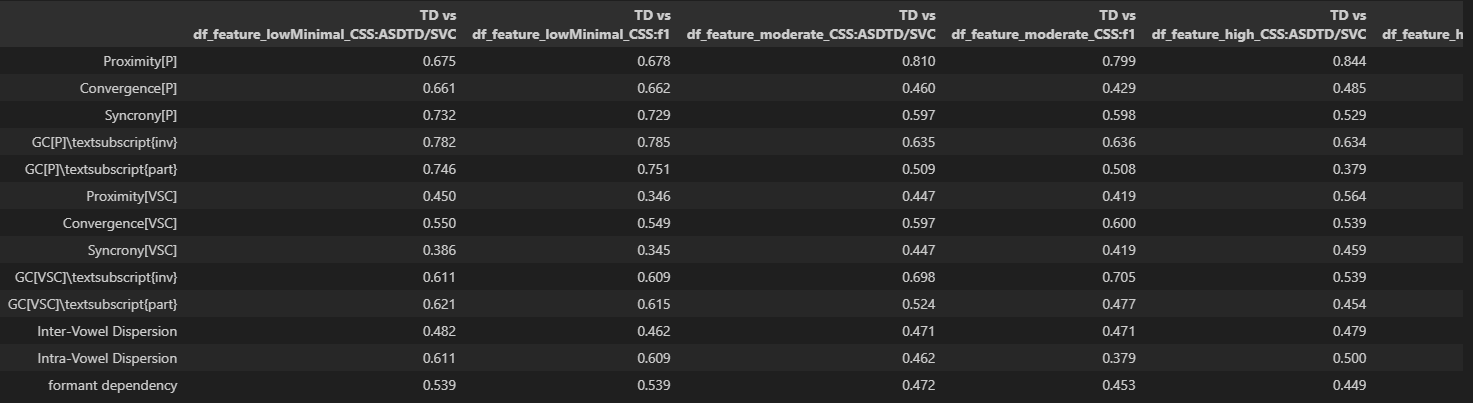

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Apr 16 15:41:44 2022

@author: jackchen
"""

import os, glob
import pandas as pd
import numpy as np
import re
from addict import Dict
import articulation.HYPERPARAM.FeatureSelect as FeatSel
import articulation.HYPERPARAM.PaperNameMapping as PprNmeMp
import argparse
from itertools import combinations, product

def Swap2PaperName(feature_rawname,PprNmeMp):
    if feature_rawname in PprNmeMp.Paper_name_map.keys():
        featurename_paper=PprNmeMp.Paper_name_map[feature_rawname]
        feature_keys=featurename_paper
    else: 
        feature_keys=feature_rawname
    return feature_keys
def Inverse_Swap2PaperName(feature_rawname,PprNmeMp):
    if feature_rawname in PprNmeMp.Inverse_Paper_name_map.keys():
        featurename_paper=PprNmeMp.Inverse_Paper_name_map[feature_rawname]
        feature_keys=featurename_paper
    else: 
        feature_keys=feature_rawname
    return feature_keys

def get_args():
    # we add compulsary arguments as named arguments for readability
    parser = argparse.ArgumentParser()
    parser.add_argument('--knn_weights', default='uniform',
                                help='path of the base directory')
    parser.add_argument('--knn_neighbors', default=2,  type=int,
                            help='path of the base directory')
    parser.add_argument('--Reorder_type', default='DKIndividual',
                            help='[DKIndividual, DKcriteria]')
    parser.add_argument('--FeatureComb_mode', default='baselineFeats',
                            help='[Add_UttLvl_feature, feat_comb3, feat_comb5, feat_comb6,feat_comb7, baselineFeats,Comb_dynPhonation,Comb_staticLOCDEP_dynamicLOCDEP_dynamicphonation,Comb_staticLOCDEP_dynamicLOCDEP_dynamicphonation_Add_UttLvl_feature]')
    args = parser.parse_args(args=[])
    return args

args = get_args()
knn_weights=args.knn_weights
knn_neighbors=args.knn_neighbors
Reorder_type=args.Reorder_type
FeatureComb_mode=args.FeatureComb_mode
# =============================================================================
'''

    This code is to reorganize the prediction results and facilitate generating 
    nice tables 

'''

SecondLvl_strmapp={
    # 'Vowel Dispersion+formant dependency':'vowel space characteristics(VSC)'
    'Vowel Dispersion+formant dependency':'VSC'
    }
# =============================================================================
# 
# '''

#     Check results from Classification fusion results

# '''
# ['TD vs df_feature_lowMinimal_CSS', 'TD vs df_feature_moderatehigh_CSS',
#        'TD vs df_feature_NotautismandASD_TC', 'TD vs df_feature_Autism_TC',
#        'TD vs df_feature_NotautismandASD_TS', 'TD vs df_feature_Autism_TS',
#        'TD vs df_feature_NotautismandASD_TSC', 'TD vs df_feature_Autism_TSC']
# exp_pair1=['TD vs df_feature_lowMinimal_CSS', 'TD vs df_feature_moderatehigh_CSS']
# exp_pair2=['TD vs df_feature_NotautismandASD_TC', 'TD vs df_feature_Autism_TC']
# exp_pair3=['TD vs df_feature_NotautismandASD_TS', 'TD vs df_feature_Autism_TS']
# exp_pair4=['TD vs df_feature_NotautismandASD_TSC', 'TD vs df_feature_Autism_TSC']
# Exp_pairs=[exp_pair1,exp_pair2,exp_pair3,exp_pair4]
# With_staticphonation_analysis_cols_bool=False
# =============================================================================


    

# =============================================================================
'''

    Reading from classification results

'''
''' Columns_comb3 = All possible feature combination + phonation_proximity_col :: Main analysis 1-2'''
''' Columns_comb5 = All possible feature combination + Phonation_Syncrony_cols :: Main analysis 1-2'''
''' Columns_comb5 = All possible feature combination + Phonation_Syncrony_cols :: Main analysis 2'''
path="RESULTS/Fusion_result/{FeatureComb_mode}/".format(FeatureComb_mode=args.FeatureComb_mode)

# =============================================================================
manual_selected_settingXlsxFile= path+'Regression_{knn_weights}_{knn_neighbors}_{Reorder_type}.xlsx'.format(knn_weights=knn_weights,knn_neighbors=knn_neighbors,Reorder_type=Reorder_type)
file = manual_selected_settingXlsxFile

nameOfFile=os.path.basename(file).replace(".xlsx","")
df_result_file=pd.read_excel(file, index_col=0)

Regress_column_name='ADOS_C/SVR (MSE/pear/spear)'
# df_result_file[Regress_column_name]

columns_sel=['MSE','pear','spear','CCC']


df_result_dicts=Dict()
for cols in df_result_file.columns:
    exp_str=cols.split(" ")[0]
    df_Managed_result=pd.DataFrame([],columns=columns_sel)
    for idx in df_result_file.index:
        
        # df_Managed_result.name=exp_str
        feature_module_str=idx.split("-",1)[-1]
        result_str=df_result_file.loc[idx,cols]
        result_lst= [float(r) for r in result_str.split("/")]
        df_Managed_result.loc[feature_module_str]=result_lst
    
    df_result_dicts[exp_str]=df_Managed_result
df_ManagedResult_regression=df_result_dicts['ADOS_C/SVR']
Index_arrangement_lst=[
    'Proximity[P]',
    'Convergence[P]',
    'Syncrony[P]',
    'GC[P]\\textsubscript{inv}',
    'GC[P]\\textsubscript{part}',
    'Proximity[VSC]',
    'Convergence[VSC]',
    'Syncrony[VSC]',
    'GC[VSC]\\textsubscript{inv}',
    'GC[VSC]\\textsubscript{part}',
    'Inter-Vowel Dispersion',
    'Intra-Vowel Dispersion',
    'formant dependency',
    ]
df_ManagedResult_regression=df_ManagedResult_regression.loc[Index_arrangement_lst]



df_ManagedResult_regression


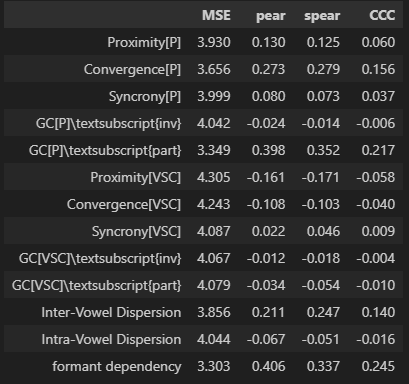